# 8.8. Projetando Arquiteturas de Redes de Convolução

As seções anteriores nos levaram a um tour pelo design de rede moderno para visão computacional. Comum a todo o trabalho que cobrimos era que ele dependia muito da intuição dos cientistas. Muitas das arquiteturas são fortemente informadas pela criatividade humana e, em muito menor extensão, pela exploração sistemática do espaço de design que as redes profundas oferecem. No entanto, essa abordagem de engenharia de rede tem sido tremendamente bem-sucedida.

Até agora, omitimos redes obtidas por meio de __Busca de Arquitetura Neural (Neural Architecture Search - NAS)__ ( Liu et al. , 2018 , Zoph e Le, 2016 ) . Escolhemos fazer isso porque seu custo geralmente é enorme, dependendo de busca de força bruta, algoritmos genéticos, aprendizado por reforço ou alguma outra forma de otimização de hiperparâmetros. Dado um espaço de busca fixo, o NAS usa uma estratégia de busca para selecionar automaticamente uma arquitetura com base na estimativa de desempenho retornada. O resultado do NAS é uma única instância de rede. EfficientNets são um resultado notável dessa busca ( Tan e Le, 2019 ).

A seguir, discutiremos uma ideia que é bem diferente da busca pela melhor rede única . É computacionalmente relativamente barata, leva a insights científicos no caminho e é bem eficaz em termos de qualidade dos resultados. Vamos revisar a estratégia de Radosavovic et al. ( 2020 ) para projetar espaços de design de rede . A estratégia combina a força do design manual e NAS. Ela faz isso operando em distribuições de redes e otimizando as distribuições de forma a obter bom desempenho para famílias inteiras de redes. O resultado disso são RegNets , especificamente RegNetX e RegNetY, além de uma gama de princípios orientadores para o design de CNNs de alto desempenho.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 8.8.1. O Espaço de Design AnyNet

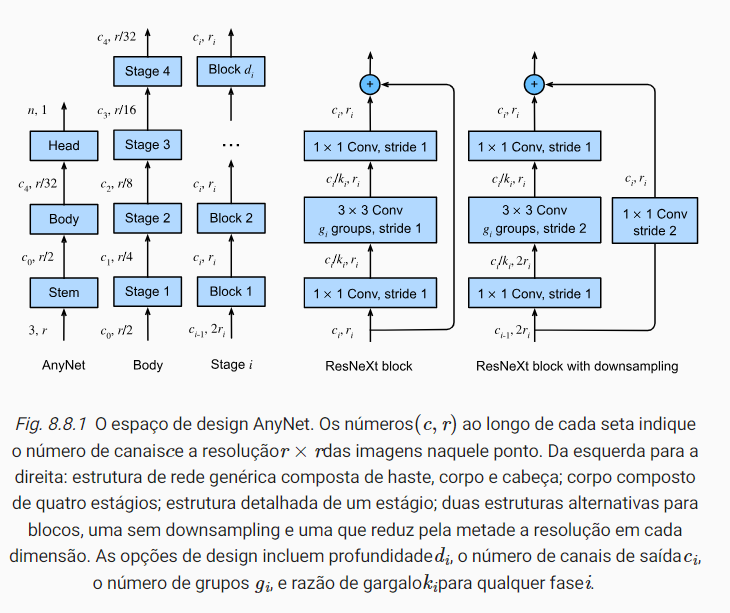

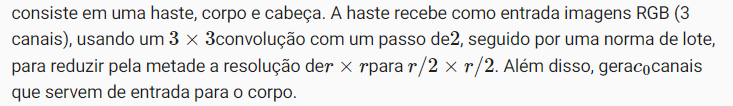

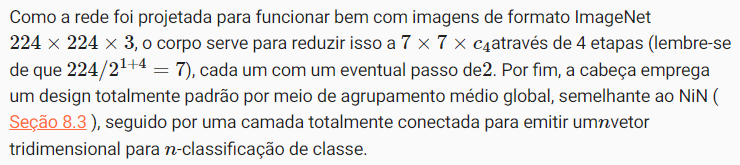



Cada estágio é composto por blocos do tipo ResNeXt.

Por fim, como estamos lidando com blocos ResNeXt, também precisamos escolher o número de grupos gi para convoluções agrupadas no estágio i.

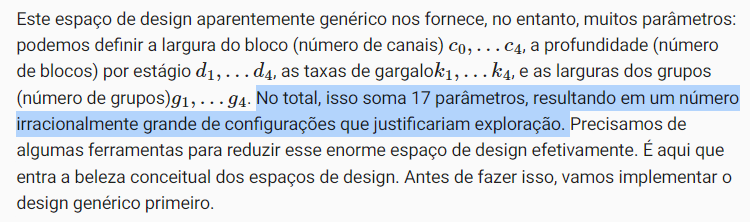

In [6]:
class AnyNet(d2l.Classifier):
    def stem(self, num_channels):           # stem: tronco
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

# Sequência original:    Conv ->  BN  -> ReLU    (Utilizando a original)
# Sequência modificada:    BN -> ReLU -> Conv

Cada estágio consiste em depth blocos ResNeXt, onde num_channels especifica a largura do bloco. Observe que o primeiro bloco divide pela metade a altura e a largura das imagens de entrada.

In [7]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):    # cada estágio consiste em blocos ResNeXt de largura num_channels.
    blk = []
    for i in range(depth):                                # depth é a profundidade = quantidade de blocos que o estágio possui.
        if i == 0:                                        # i=0 corresponde ao 1º bloco.
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))             # o 1º bloco divide pela metade (strides=2) a altura/largura das imagens de entrada.
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

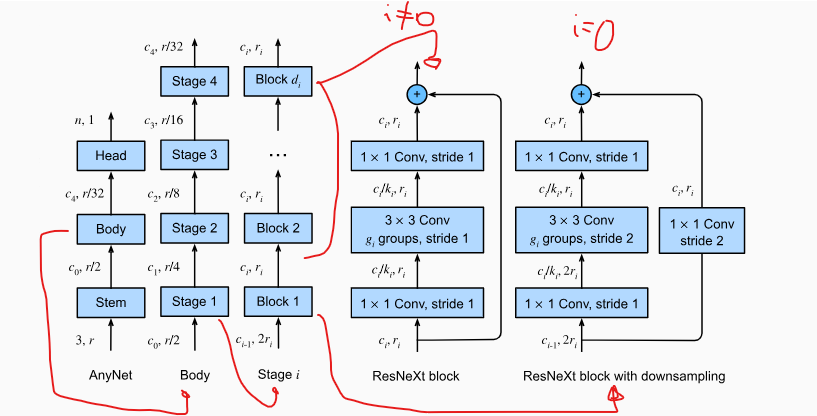

Ao juntar a haste/tronco, o corpo e a cabeça da rede, concluímos a implementação do AnyNet.

In [8]:
# A configuração AnyNet é baseada em blocos ResNeXt
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    
    self.net = nn.Sequential(self.stem(stem_channels))       # stem = tronco.
    
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))   # estágios.
    
    self.net.add_module('head', nn.Sequential(               # head.
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)                             # aplica a inicialização Xavier.

# 8.8.2. Distribuições e Parâmetros de Espaços de Projeto

Conforme discutido na Seção 8.8.1 , os parâmetros de um espaço de design são hiperparâmetros de redes nesse espaço de design. Considere o problema de identificar bons parâmetros no espaço de design AnyNet. Poderíamos tentar encontrar a melhor escolha de parâmetro para uma determinada quantidade de computação (por exemplo, FLOPs e tempo de computação). Se permitíssemos apenas duas escolhas possíveis para cada parâmetro, teríamos que explorar 2^17=131072 combinações para encontrar a melhor solução. Isso é claramente inviável devido ao seu custo exorbitante.

Uma estratégia melhor seria tentar determinar __diretrizes gerais__ de como as escolhas de parâmetros devem ser relacionadas. Por exemplo, a taxa de gargalo, o número de canais, blocos, grupos ou sua mudança entre camadas devem, idealmente, ser __governados por uma coleção de regras simples__. A abordagem em Radosavovic et al. ( 2019 ) baseia-se nas quatro suposições a seguir:

- Presumimos que os princípios gerais de design realmente existem, de modo que muitas redes que satisfazem esses requisitos __devem oferecer bom desempenho__. Consequentemente, identificar uma distribuição sobre redes pode ser uma estratégia sensata. Em outras palavras, presumimos que há muitas agulhas boas no palheiro.

- __Não precisamos treinar redes para convergência antes de podermos avaliar se uma rede é boa. Em vez disso, é suficiente usar os resultados intermediários como orientação confiável para precisão final.__ Usar proxies (aproximados) para otimizar um objetivo é chamado de otimização de multifidelidade ( Forrester et al. , 2007 ) . Consequentemente, __a otimização do design é realizada com base na precisão alcançada após apenas algumas passagens pelo conjunto de dados, reduzindo significativamente o custo.__

- __Resultados obtidos em uma escala menor (para redes menores) generalizam para redes maiores.__ Consequentemente, a otimização é realizada para redes que são estruturalmente similares, mas com um número menor de blocos, menos canais, etc. __Somente no final precisaremos verificar se as redes assim encontradas também oferecem bom desempenho em escala.__

- Aspectos do design podem ser __aproximadamente fatorados__ para que seja possível inferir seu efeito na qualidade do resultado de forma um tanto independente. Em outras palavras, o problema de otimização é moderadamente fácil.

Essas suposições nos permitem testar muitas redes de forma barata. Posteriormente, podemos avaliar a qualidade da escolha dos parâmetros revisando a distribuição de erro/precisão que pode ser alcançada com as ditas redes.



# 8.8.3. Rede Reg

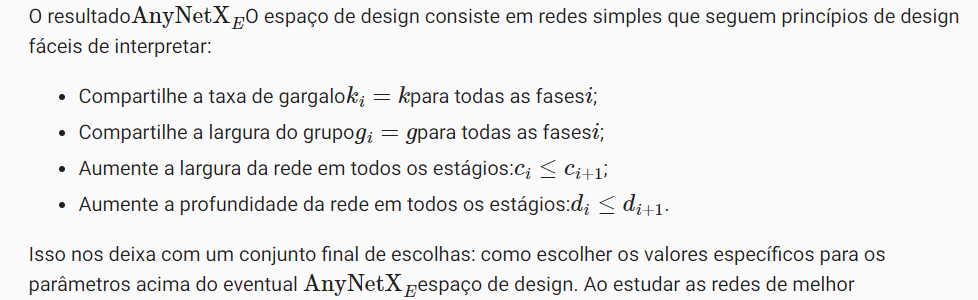

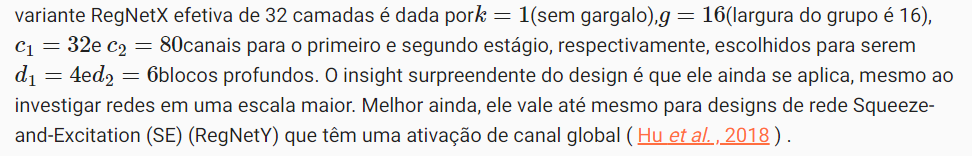

In [9]:
class RegNetX32(AnyNet):                              # RegNetX32 herda os atributos da classe mãe AnyNet 
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1    # stem_channels = 32, groups = 16, bot_mul(k) = 1 (sem gargalo)
        depths, channels = (4, 6), (32, 80)           # 2 estágios
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),   # depths[0] = 4, channels[0] = 32
             (depths[1], channels[1], groups, bot_mul)),  # depths[1] = 6, channels[1] = 80
            stem_channels, lr, num_classes)

Podemos ver que cada estágio do RegNetX reduz progressivamente a resolução e aumenta os canais de saída.

In [10]:
RegNetX32().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 32, 48, 48])
Sequential output shape:	 torch.Size([1, 32, 24, 24])
Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])


# 8.8.4. Treinamento

O treinamento do RegNetX de 32 camadas no conjunto de dados Fashion-MNIST é feito como antes.

In [ ]:
model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

# 8.8.5. Discussão

Com vieses indutivos desejáveis (suposições ou preferências) como localidade e invariância de tradução ( Seção 7.1 ) para visão, CNNs têm sido as arquiteturas dominantes nesta área. Este permaneceu o caso de LeNet até Transformers ( Seção 11.7 ) ( Dosovitskiy et al. , 2021 , Touvron et al. , 2021 ) começarem a superar CNNs em termos de precisão. Embora muito do progresso recente em termos de Transformers de visão possa ser retroportado para CNNs ( Liu et al. , 2022 ) , isso só é possível a um custo computacional mais alto. Tão importante quanto isso, otimizações de hardware recentes (NVIDIA Ampere e Hopper) apenas aumentaram a lacuna em favor dos Transformers.

Em suma, os Transformers de visão ( Seção 11.8 ) agora lideram em termos de desempenho de última geração em classificação de imagens em larga escala, mostrando que a escalabilidade supera os vieses indutivos ( Dosovitskiy et al. , 2021 ) . Isso inclui o pré-treinamento de Transformers em larga escala ( Seção 11.9 ) com autoatenção multicabeça ( Seção 11.5 ). Convidamos os leitores a mergulhar nesses capítulos para uma discussão muito mais detalhada.

# Código Agrupado

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# ------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.

# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)

# ALTERO APENAS A FUNÇÃO ESPECÍFICA DA CLASSE ORIGINAL UTILIZANDO DECORATOR.
@d2l.add_to_class(d2l.FashionMNIST)
def get_dataloader(self, train):
    """Defined in :numref:`sec_fashion_mnist`"""
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=0)

# -----------------------------------------------------------------------
#------------------------------------------------------------------------

class AnyNet(d2l.Classifier):
    def stem(self, num_channels):           # stem: tronco
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

# Sequência original:    Conv ->  BN  -> ReLU    (Utilizando a original)
# Sequência modificada:    BN -> ReLU -> Conv

#------------------------------------------------------------------------

# Design principles:
# depth:        depth            (profundidade)
# channels:     num_channels     (canais) 
# group:        groups           (grupos)
# bottleneck:   bot_mul          (gargalos)
 @d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):    # cada estágio consiste em blocos ResNeXt de largura num_channels.
    blk = []
    for i in range(depth):                                # depth é a profundidade = quantidade de blocos que o estágio possui.
        if i == 0:                                        # i=0 corresponde ao 1º bloco.
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))             # o 1º bloco divide pela metade (strides=2) a altura/largura das imagens de entrada.
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

#------------------------------------------------------------------------

# A configuração AnyNet é baseada em blocos ResNeXt
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    
    self.net = nn.Sequential(self.stem(stem_channels))       # stem = tronco.
    
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))   # estágios.
    
    self.net.add_module('head', nn.Sequential(               # head.
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)                             # aplica a inicialização Xavier.

#------------------------------------------------------------------------

class RegNetX32(AnyNet):                              # RegNetX32 herda os atributos da classe mãe AnyNet 
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1    # stem_channels = 32, groups = 16, bot_mul(k) = 1 (sem gargalo)
        depths, channels = (4, 6), (32, 80)           # 2 estágios
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),   # depths[0] = 4, channels[0] = 32
             (depths[1], channels[1], groups, bot_mul)),  # depths[1] = 6, channels[1] = 80
            stem_channels, lr, num_classes)

#------------------------------------------------------------------------

model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

#------------------------------------------------------------------------

https://colab.research.google.com/drive/1ZZA1mA4svEhVWz00P1gHqYBZz2zwG-fc#scrollTo=6OvSCud2Ybtj

# 8.8.6. Exercícios

https://colab.research.google.com/drive/1ZZA1mA4svEhVWz00P1gHqYBZz2zwG-fc#scrollTo=MD51zhVeuZgV&uniqifier=1

# Outras respostas:

https://pandalab.me/archives/designing_convolution_network_architectures

# Visão Geral de Design Efetivo - Serve para qualquer tipo de rede

# 4. Your goal is to design the “perfect” MLP. Can you use the design principles introduced above to find good architectures? Is it possible to extrapolate from small to large networks?

Designing the “perfect” Multilayer Perceptron (MLP) involves careful consideration of architectural choices to achieve high performance on a specific task. The paper “On Network Design Spaces for Visual Recognition” discusses several design principles that can be applied to create effective neural network architectures for visual recognition. Here’s how you can use these design principles to design an effective MLP:

1. __Depth and Width:__

- Depth: Experiment with different numbers of layers (depth) in your MLP. Start with a moderate depth and gradually increase it while monitoring performance. Deep networks can capture complex features but may require techniques like skip connections (ResNets) to mitigate vanishing gradients.

- Width: Vary the number of neurons (width) in each layer. Wider layers can capture more complex patterns, but they may also increase the risk of overfitting. You can use techniques like dropout or batch normalization to regularize the network.

2. __Skip Connections:__

- Consider adding skip connections between layers, similar to Residual Networks (ResNets). These connections can help alleviate vanishing gradient problems and enable the training of very deep networks.

3. __Kernel Sizes:__

- Experiment with different kernel sizes for convolutional layers or different numbers of neurons in fully connected layers. Smaller kernels can capture fine details, while larger kernels can capture broader patterns.

4. __Pooling Strategies:__

- Use different pooling strategies like max-pooling or average pooling to downsample feature maps. The choice of pooling can affect the invariance and spatial resolution of the learned features.

5. __Normalization:__

- Incorporate batch normalization layers to stabilize training and improve convergence. Batch normalization can also act as a regularize.

6. __Activation Functions:__

- Experiment with different activation functions like ReLU, Leaky ReLU, or variants like Swish. The choice of activation function can affect the network’s capacity to model complex data distributions.

7. __Dropout:__

- Apply dropout with varying dropout rates to prevent overfitting. You can selectively apply dropout to certain layers or neurons based on their importance.

8. __Initialization:__

- Use appropriate weight initialization techniques such as Xavier/Glorot initialization or He initialization. Proper initialization can expedite training and improve convergence.

9. __Normalization Layers:__

- Experiment with layer normalization or group normalization in addition to batch normalization to see if they offer advantages in your specific task.

10. __Optimizers and Learning Rates:__

- Choose appropriate optimizers (e.g., Adam, SGD) and learning rate schedules. Learning rate schedules like learning rate annealing or cyclic learning rates can help in training.

11. __Regularization Techniques:__

- Consider L1 and L2 regularization to control the complexity of the model and prevent overfitting. You can also explore more advanced regularization techniques like dropout, weight decay, or early stopping.

12. __Task-Specific Architectures:__

- Tailor your MLP architecture to the specific task. For example, use a final softmax layer for classification tasks or a linear layer for regression tasks.

13. __Ensemble Learning:__

- Experiment with ensemble methods to combine multiple MLPs for improved performance and robustness.

14. __Hyperparameter Search:__

- Perform systematic hyperparameter tuning using techniques like grid search or random search to find the best combination of hyperparameters.

15. __Transfer Learning:__

- Consider using transfer learning by initializing your MLP with pretrained weights from a model trained on a related task. Fine-tuning the network on your specific task can significantly boost performance.

16. __Data Augmentation:__

- Apply data augmentation techniques to increase the effective size of your training dataset and improve the model’s generalization.

17. __Regularly Evaluate Performance:__

- Continuously monitor and evaluate the model’s performance on a validation dataset. Adjust architectural choices based on performance feedback.

Remember that designing the “perfect” MLP involves an iterative process of experimentation, evaluation, and refinement. The choice of architecture and design principles should align with the specific requirements and constraints of your task and dataset.